In [1]:
from PIL import Image

img = Image.open(r"C:.\Nutrition5K\Nutrition5K\train\color\dish_0000\rgb.png")
print(img.size)  # 输出 (W, H)

(640, 480)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    """Basic conv block: Conv -> BN -> ReLU"""
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    """
    Ultra-small CNN for RGB-D regression.
    - Early fusion: set in_ch=4 to accept RGB(3)+Depth(1)
    - By default uses standard GAP (no mask).
    - You can enable masked-GAP later via use_mask=True and passing a mask tensor to forward().
    """
    def __init__(self, in_ch=4, widths=(24, 48, 96, 128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1, w2, w3, w4 = widths

        # Stem -> H/2
        self.stem = nn.Sequential(
            ConvBNReLU(in_ch, w1, k=3, s=2, p=1),
            ConvBNReLU(w1, w1, k=3, s=1, p=1),
        )
        # Stage1 -> H/4
        self.stage1 = nn.Sequential(
            ConvBNReLU(w1, w2, k=3, s=2, p=1),
            ConvBNReLU(w2, w2, k=3, s=1, p=1),
        )
        # Stage2 -> H/8
        self.stage2 = nn.Sequential(
            ConvBNReLU(w2, w3, k=3, s=2, p=1),
            ConvBNReLU(w3, w3, k=3, s=1, p=1),
        )
        # Stage3 -> H/16
        self.stage3 = nn.Sequential(
            ConvBNReLU(w3, w4, k=3, s=2, p=1),
            ConvBNReLU(w4, w4, k=3, s=1, p=1),
        )

        # Head: GAP/Masked-GAP -> Dropout -> MLP(128) -> Linear(out_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1     = nn.Linear(w4, 128)
        self.fc2     = nn.Linear(128, out_dim)  # regression head (no activation)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)   # [B, C, H/16, W/16]
        return x

    @staticmethod
    def masked_gap(feat: torch.Tensor, mask: torch.Tensor | None):
        """
        Optional masked global average pooling.
        If mask is None, this falls back to standard GAP outside this method.
        """
        if mask is None:
            # Should not be called when mask=None; kept for completeness.
            return F.adaptive_avg_pool2d(feat, 1).flatten(1)
        m = F.interpolate(mask, size=feat.shape[-2:], mode="nearest").clamp(0, 1)  # [B,1,Hf,Wf]
        num = (feat * m).sum(dim=(2,3))           # [B,C]
        den = (m.sum(dim=(2,3)) + 1e-6)           # [B,1]
        return num / den

    def forward(self, x, mask: torch.Tensor | None = None):
        """
        x:    [B, in_ch, H, W]  (e.g., in_ch=4 for RGB-D)
        mask: [B, 1, H, W] or None. Ignored unless self.use_mask is True.
        """
        f = self.forward_features(x)
        if self.use_mask:
            # Use masked-GAP ONLY when explicitly enabled and mask is provided.
            pooled = self.masked_gap(f, mask)
        else:
            # Standard GAP (default baseline, no mask involved).
            pooled = F.adaptive_avg_pool2d(f, 1).flatten(1)

        z = self.dropout(pooled)
        z = F.relu(self.fc1(z), inplace=True)
        out = self.fc2(z)  # [B, out_dim]
        return out

# ------- tiny self-test -------
if __name__ == "__main__":
    B, H, W = 4, 640, 480
    # Default: no mask path (use_mask=False)
    model = TinyCNN(in_ch=6, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask=False)
    x = torch.randn(B, 4, H, W)
    y = model(x)
    print("Output (no mask) shape:", y.shape)

    # # Later: enable masked-GAP easily
    # model_mask = TinyCNN(in_ch=4, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask=True)
    # m = torch.randint(0, 2, (B, 1, H, W)).float()
    # y2 = model_mask(x, mask=m)
    # print("Output (with mask) shape:", y2.shape)

In [ ]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=6, widths=(24,48,96,128), dropout=0.3, out_dim=1, use_mask: bool=False):
        super().__init__()
        self.use_mask = use_mask
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDUnifiedDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True, mode="drgb",
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225),
                 mean_drgb=(0.5,0.5,0.5), std_drgb=(0.25,0.25,0.25),
                 depth_raw_clip=(0.0,3.0)):
        super().__init__()
        self.mode, self.H, self.W = mode, *out_size
        self.augment = augment
        self.depth_raw_clip = depth_raw_clip

        # parse CSV
        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        # normalization
        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)
        self.mean_drgb= torch.tensor(mean_drgb).view(3,1,1)
        self.std_drgb = torch.tensor(std_drgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))
    def _load_raw(self, p):
        arr = np.array(Image.open(p)).astype("float32")
        if arr.max() > 50: arr /= 1000.0
        dmin,dmax = self.depth_raw_clip
        arr = np.clip(arr,dmin,dmax); arr = (arr-dmin)/max(1e-6,(dmax-dmin))
        return torch.from_numpy(arr).unsqueeze(0)

    def _geom_sync(self,a,b):
        if self.augment:
            scale=random.uniform(0.7,1.0)
            h,w=a.shape[-2:]; th,tw=int(h*scale),int(w*scale)
            i=random.randint(0,h-th) if th<h else 0
            j=random.randint(0,w-tw) if tw<w else 0
            a=TF.resized_crop(a,i,j,th,tw,(self.H,self.W))
            b=TF.resized_crop(b,i,j,th,tw,(self.H,self.W))
            ang=random.uniform(-8,8)
            a,b=TF.rotate(a,ang),TF.rotate(b,ang)
            if random.random()<0.5: a,b=TF.hflip(a),TF.hflip(b)
        else:
            a,b=TF.resize(a,(self.H,self.W)),TF.resize(b,(self.H,self.W))
        return a,b

    def __getitem__(self, idx):
        row=self.rows[idx]
        y=torch.tensor([row["label"]],dtype=torch.float32)
        rgb=self._load_img(row["rgb"])
        if self.mode=="drgb":
            drgb=self._load_img(row["drgb"])
            rgb,drgb=self._geom_sync(rgb,drgb)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            drgb=(drgb-self.mean_drgb)/(self.std_drgb+1e-6)
            x=torch.cat([rgb,drgb],0)
        else:
            draw=self._load_raw(row["draw"])
            rgb,draw=self._geom_sync(rgb,draw)
            if self.augment:
                rgb=TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
                rgb=TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
            rgb=(rgb-self.mean_rgb)/(self.std_rgb+1e-6)
            x=torch.cat([rgb,draw],0)
        return x,y,row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils (generalized AMP, seed, loader) ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


def make_loader(dataset, batch_size, shuffle, drop_last):
    # Safer defaults across OS; pin_memory only when CUDA
    num_workers = 0
    print(num_workers)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=torch.cuda.is_available(),
        persistent_workers=(num_workers > 0), drop_last=drop_last
        )

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        pred = model(x)                              # 前向
        loss = F.mse_loss(pred, y)                   # 纯 MSE（想稳一点可加 + 0.3*SmoothL1）
        # loss = F.mse_loss(pred, y) + 0.3*F.smooth_l1_loss(pred, y, beta=5.0)
        
        loss.backward()                              # 反传（FP32，无缩放）
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()                             # 更新

        total += loss.item() * x.size(0)
        n     += x.size(0)

    return total / max(1, n)

# ---------------------- Main (generalized) ----------------------
def train_tiny_cnn():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    mode = "drgb"; in_ch = 6
    idx = list(range(len(RGBDUnifiedDataset("train_index.csv", mode=mode, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))

    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDUnifiedDataset(train_csv, mode=mode, augment=True)
    val_full   = RGBDUnifiedDataset(train_csv, mode=mode, augment=False)

    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=32, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=in_ch, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)  # <--- to(device)

    # 固定学习率
    FIXED_LR = 3e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=FIXED_LR, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 25

    for ep in range(1, EPOCHS + 1):
        cur_lr = optimizer.param_groups[0]['lr']
  
        tr = train_one_epoch(model, train_loader, optimizer, device, max_grad_norm=1.0)
        val = evaluate(model, val_loader, device)

        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | LR {cur_lr:.2e} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")

        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": mode,
                "in_ch": in_ch,
            }, "tinycnn_best.pth")

    # 曲线
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("TinyCNN | Fixed LR")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


0
0
Epoch 001 | LR 3.00e-04 | Train 106687.6239 | Val MSE 93707.5989 | Val MAE 225.09
Epoch 002 | LR 3.00e-04 | Train 102392.0777 | Val MSE 87325.3519 | Val MAE 216.34
Epoch 003 | LR 3.00e-04 | Train 89872.8814 | Val MSE 80392.5951 | Val MAE 206.92
Epoch 004 | LR 3.00e-04 | Train 87752.0515 | Val MSE 74065.5602 | Val MAE 197.11
Epoch 005 | LR 3.00e-04 | Train 78743.2118 | Val MSE 70653.2591 | Val MAE 192.01
Epoch 006 | LR 3.00e-04 | Train 69274.3769 | Val MSE 51625.1909 | Val MAE 158.62
Epoch 007 | LR 3.00e-04 | Train 61041.8066 | Val MSE 43713.5876 | Val MAE 146.30
Epoch 008 | LR 3.00e-04 | Train 52982.0636 | Val MSE 33818.5045 | Val MAE 124.15
Epoch 009 | LR 3.00e-04 | Train 46644.8508 | Val MSE 41321.9155 | Val MAE 141.17
Epoch 010 | LR 3.00e-04 | Train 41397.5461 | Val MSE 23603.2910 | Val MAE 103.08
Epoch 011 | LR 3.00e-04 | Train 36146.4803 | Val MSE 24437.0040 | Val MAE 105.96
Epoch 012 | LR 3.00e-04 | Train 33521.3698 | Val MSE 18607.9941 | Val MAE 94.54
Epoch 013 | LR 3.00e-04

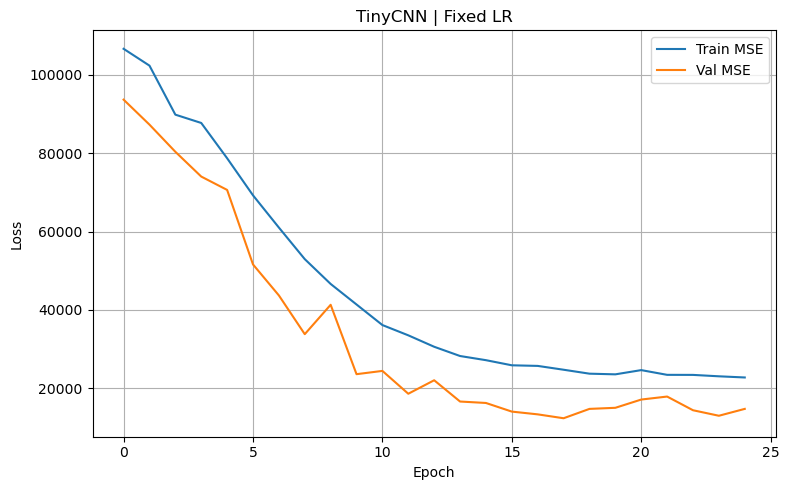

In [18]:
train_tiny_cnn()

In [ ]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1):
        super().__init__()
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                })

        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))

    def _augment(self, img):
        scale = random.uniform(0.7, 1.0)
        h,w = img.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        img = TF.resized_crop(img, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        img = TF.rotate(img, ang)
        if random.random() < 0.5: img = TF.hflip(img)
        img = TF.adjust_brightness(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_contrast(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_saturation(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_hue(img,random.uniform(-0.04,0.04))
        return img

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)
        rgb = self._load_img(row["rgb"])
        if self.augment:
            rgb = self._augment(rgb)
        else:
            rgb = TF.resize(rgb, (self.H,self.W))
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return rgb, y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total += loss.item() * x.size(0)
        n     += x.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tiny_cnn_only_color():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    idx = list(range(len(RGBDataset(train_csv, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))
    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDataset(train_csv, augment=True)
    val_full   = RGBDataset(train_csv, augment=False)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgb",
                "in_ch": 3,
            }, "tinycnn_rgb_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN (RGB Only)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


Epoch 001 | Train 107331.1360 | Val MSE 94761.3258 | Val MAE 226.69
Epoch 002 | Train 105034.0566 | Val MSE 93330.0633 | Val MAE 224.39
Epoch 003 | Train 102953.4485 | Val MSE 90564.8884 | Val MAE 219.89
Epoch 004 | Train 99894.6648 | Val MSE 88930.7739 | Val MAE 218.18
Epoch 005 | Train 96158.3917 | Val MSE 85730.1684 | Val MAE 213.43
Epoch 006 | Train 92688.2928 | Val MSE 81722.1284 | Val MAE 206.95
Epoch 007 | Train 88681.2929 | Val MSE 72681.6773 | Val MAE 192.23
Epoch 008 | Train 84817.0049 | Val MSE 72904.8669 | Val MAE 193.33
Epoch 009 | Train 80730.2137 | Val MSE 75899.1313 | Val MAE 198.97
Epoch 010 | Train 76166.2190 | Val MSE 65760.4794 | Val MAE 181.02
Epoch 011 | Train 71947.8014 | Val MSE 58156.3280 | Val MAE 169.02
Epoch 012 | Train 66926.7700 | Val MSE 59329.3420 | Val MAE 171.53
Epoch 013 | Train 62242.0628 | Val MSE 46110.0504 | Val MAE 147.59
Epoch 014 | Train 58197.6981 | Val MSE 40972.8891 | Val MAE 138.04
Epoch 015 | Train 53940.7698 | Val MSE 49614.9057 | Val MAE

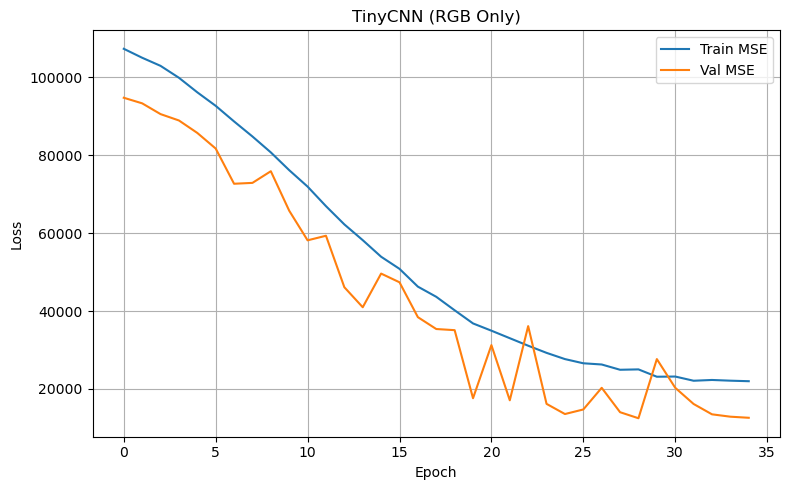

In [26]:
train_tiny_cnn_only_color()

In [29]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------- TinyCNN ----------------------
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1):
        super().__init__()
        w1,w2,w3,w4 = widths
        self.stem  = nn.Sequential(ConvBNReLU(in_ch,w1,3,2,1), ConvBNReLU(w1,w1,3,1,1))
        self.s1    = nn.Sequential(ConvBNReLU(w1,w2,3,2,1),  ConvBNReLU(w2,w2,3,1,1))
        self.s2    = nn.Sequential(ConvBNReLU(w2,w3,3,2,1),  ConvBNReLU(w3,w3,3,1,1))
        self.s3    = nn.Sequential(ConvBNReLU(w3,w4,3,2,1),  ConvBNReLU(w4,w4,3,1,1))
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(w4, 128)
        self.fc2   = nn.Linear(128, out_dim)
    def forward(self, x):
        f = self.s3(self.s2(self.s1(self.stem(x))))
        z = F.adaptive_avg_pool2d(f, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Dataset ----------------------
class RGBDataset(Dataset):
    """CSV columns: dish_id,label,rgb_path"""
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.485,0.456,0.406), std_rgb=(0.229,0.224,0.225)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["depth_color_path"]],
                })

        self.mean_rgb = torch.tensor(mean_rgb).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb ).view(3,1,1)

    def _load_img(self, p): return TF.to_tensor(Image.open(p).convert("RGB"))

    def _augment(self, img):
        scale = random.uniform(0.7, 1.0)
        h,w = img.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        img = TF.resized_crop(img, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        img = TF.rotate(img, ang)
        if random.random() < 0.5: img = TF.hflip(img)
        img = TF.adjust_brightness(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_contrast(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_saturation(img,1+random.uniform(-0.2,0.2))
        img = TF.adjust_hue(img,random.uniform(-0.04,0.04))
        return img

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)
        rgb = self._load_img(row["rgb"])
        if self.augment:
            rgb = self._augment(rgb)
        else:
            rgb = TF.resize(rgb, (self.H,self.W))
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return rgb, y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for x,y,_ in loader:
        x,y=x.to(device, non_blocking=True),y.to(device, non_blocking=True)
        p=model(x)
        mse_sum+=F.mse_loss(p,y,reduction="sum").item()
        mae_sum+=torch.abs(p-y).sum().item(); n+=y.size(0)
    return {"MSE":mse_sum/n,"MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total += loss.item() * x.size(0)
        n     += x.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tiny_cnn_only_rgb_depth():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"
    idx = list(range(len(RGBDataset(train_csv, augment=False))))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))
    val_idx, train_idx = idx[:k], idx[k:]

    train_full = RGBDataset(train_csv, augment=True)
    val_full   = RGBDataset(train_csv, augment=False)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    model = TinyCNN(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgb",
                "in_ch": 3,
            }, "tinycnn_rgb_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN (RGB Only)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


Epoch 001 | Train 107435.2565 | Val MSE 95143.1903 | Val MAE 227.10
Epoch 002 | Train 105347.8053 | Val MSE 93628.0178 | Val MAE 224.57
Epoch 003 | Train 103541.9546 | Val MSE 91474.1492 | Val MAE 221.49
Epoch 004 | Train 100722.8165 | Val MSE 83445.6670 | Val MAE 209.10
Epoch 005 | Train 97425.9984 | Val MSE 83648.6015 | Val MAE 210.23
Epoch 006 | Train 93859.2369 | Val MSE 80411.0439 | Val MAE 205.62
Epoch 007 | Train 89360.7574 | Val MSE 64537.5350 | Val MAE 178.13
Epoch 008 | Train 85463.9000 | Val MSE 64356.8311 | Val MAE 179.33
Epoch 009 | Train 80855.5805 | Val MSE 64652.5981 | Val MAE 180.22
Epoch 010 | Train 76056.5974 | Val MSE 54333.7197 | Val MAE 162.93
Epoch 011 | Train 72155.4346 | Val MSE 52078.4939 | Val MAE 159.39
Epoch 012 | Train 66762.4884 | Val MSE 58266.0346 | Val MAE 171.72
Epoch 013 | Train 62338.6082 | Val MSE 64616.4723 | Val MAE 182.85
Epoch 014 | Train 58204.7459 | Val MSE 44888.0932 | Val MAE 147.06
Epoch 015 | Train 53849.9636 | Val MSE 59522.5949 | Val MA

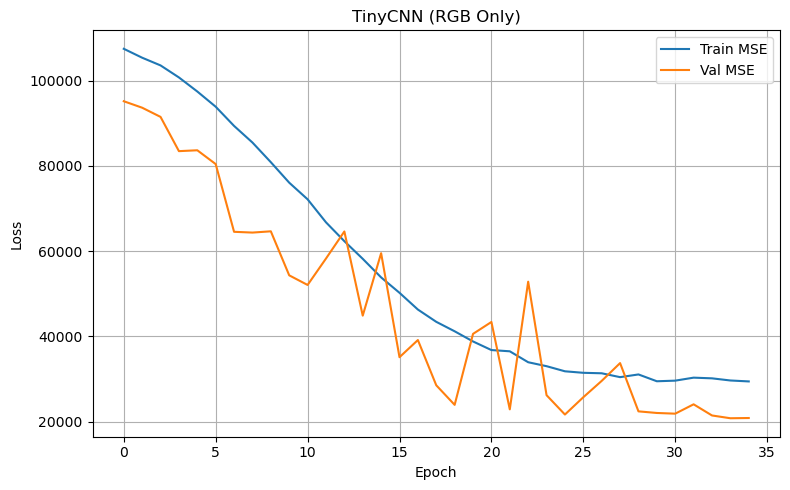

In [30]:
train_tiny_cnn_only_rgb_depth()

In [ ]:
# -*- coding: utf-8 -*-
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# ---------------------- Depth-aware TinyCNN ----------------------
class DepthAwareConv2dLite(nn.Module):
    """
    Minimal depth-aware conv:
      y(p0) = sum_{pn} W(pn) * [ softmax_{pn}(-alpha * |D(p0)-D(p0+pn)|) * x(p0+pn) ]
    Implemented via unfold (im2col) + einsum. Kernel fixed to k=3.
    """
    def __init__(self, in_channels, out_channels, stride=1, padding=1, bias=False, alpha_init=4.0):
        super().__init__()
        self.in_c  = in_channels
        self.out_c = out_channels
        self.k     = 3
        self.s     = stride
        self.p     = padding

        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, self.k, self.k))
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

        # learnable alpha (>0) with softplus
        self.alpha_raw = nn.Parameter(torch.tensor(1.0))
        with torch.no_grad():
            self.alpha_raw.copy_(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0))

        self.center_idx = 4  # center of 3x3

    @staticmethod
    def _norm01_per_image(D, eps=1e-6):
        # D: [B,1,H,W] -> per-image [0,1]
        dmin = D.amin(dim=(2,3), keepdim=True)
        dmax = D.amax(dim=(2,3), keepdim=True)
        return (D - dmin) / (dmax - dmin + eps)

    def forward(self, x, depth):
        """
        x:     [B, C_in, H, W]
        depth: [B, 1,    H, W]
        """
        B, C, H, W = x.shape
        k, s, p = self.k, self.s, self.p

        # 1) per-image depth normalization
        D = self._norm01_per_image(depth)

        # 2) unfold
        x_win = F.unfold(x, kernel_size=k, padding=p, stride=s)  # [B, C*k*k, L]
        D_win = F.unfold(D, kernel_size=k, padding=p, stride=s)  # [B, 1*k*k, L]
        L = x_win.shape[-1]

        # 3) softmax weights by depth similarity
        D_win = D_win.view(B, k*k, L)                 # [B, 9, L]
        D_ctr = D_win[:, self.center_idx:self.center_idx+1, :]
        alpha = F.softplus(self.alpha_raw)
        score = -alpha * (D_ctr - D_win).abs()        # [B, 9, L]
        a = torch.softmax(score, dim=1)

        # 4) apply weights
        x_win = x_win.view(B, C, k*k, L)              # [B, C, 9, L]
        x_mod = x_win * a[:, None, :, :]              # [B, C, 9, L]
        x_mod = x_mod.view(B, C*k*k, L)               # [B, C*9, L]

        # 5) linear projection
        Wmat = self.weight.view(self.weight.shape[0], -1)  # [out_ch, in_ch*k*k]
        y_cols = torch.einsum('oc,bcl->bol', Wmat, x_mod)
        if self.bias is not None:
            y_cols = y_cols + self.bias.view(1, -1, 1)

        # 6) fold
        H_out = (H + 2*p - k)//s + 1
        W_out = (W + 2*p - k)//s + 1
        y = y_cols.view(B, self.out_c, H_out, W_out)
        return y

class DAConvBNReLU(nn.Module):
    """Conv-BN-ReLU where conv is depth-aware and needs depth in forward."""
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, alpha_init=4.0):
        super().__init__()
        assert k == 3, "Minimal version supports k=3."
        self.conv = DepthAwareConv2dLite(in_ch, out_ch, stride=s, padding=p, bias=False, alpha_init=alpha_init)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x, depth):
        y = self.conv(x, depth)
        y = self.bn(y)
        return self.act(y)

class TinyCNN_DA_Min(nn.Module):
    """
    Replace the first conv in each stage by depth-aware convs.
    forward(rgb, depth)
    """
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1, alpha_init=4.0):
        super().__init__()
        w1, w2, w3, w4 = widths

        self.stem_da  = DAConvBNReLU(in_ch, w1, k=3, s=2, p=1, alpha_init=alpha_init)
        self.stem_n   = nn.Sequential(
            nn.Conv2d(w1, w1, 3, 1, 1, bias=False), nn.BatchNorm2d(w1, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s1_da    = DAConvBNReLU(w1, w2, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s1_n     = nn.Sequential(
            nn.Conv2d(w2, w2, 3, 1, 1, bias=False), nn.BatchNorm2d(w2, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s2_da    = DAConvBNReLU(w2, w3, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s2_n     = nn.Sequential(
            nn.Conv2d(w3, w3, 3, 1, 1, bias=False), nn.BatchNorm2d(w3, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s3_da    = DAConvBNReLU(w3, w4, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s3_n     = nn.Sequential(
            nn.Conv2d(w4, w4, 3, 1, 1, bias=False), nn.BatchNorm2d(w4, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )

        self.drop = nn.Dropout(dropout)
        self.fc1  = nn.Linear(w4, 128)
        self.fc2  = nn.Linear(128, out_dim)

    def forward(self, rgb, depth):
        # depth pyramid（nearest，保持物理语义）
        D0 = depth                                  # [B,1,H,  W]
        x  = self.stem_da(rgb, D0); x = self.stem_n(x)

        D1 = F.interpolate(D0, scale_factor=0.5, mode="nearest")   # [B,1,H/2,  W/2]
        x  = self.s1_da(x, D1);     x = self.s1_n(x)

        D2 = F.interpolate(D1, scale_factor=0.5, mode="nearest")   # [B,1,H/4,  W/4]
        x  = self.s2_da(x, D2);     x = self.s2_n(x)

        D3 = F.interpolate(D2, scale_factor=0.5, mode="nearest")   # [B,1,H/8,  W/8]
        x  = self.s3_da(x, D3);     x = self.s3_n(x)

        z = F.adaptive_avg_pool2d(x, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Mean/Std (RGB) from training CSV ----------------------
def compute_rgb_mean_std_from_csv(csv_file, root='.'):
    """
    Compute per-channel mean/std on your training RGB images.
    Image read with PIL->tensor in [0,1]. Robust to missing files.
    """
    sum_c = np.zeros(3, dtype=np.float64)
    sqsum_c = np.zeros(3, dtype=np.float64)
    count = 0

    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        header = next(reader)
        col = {h:i for i,h in enumerate(header)}
        for r in reader:
            p = os.path.join(root, r[col["rgb_path"]]).replace('\\','/')
            try:
                img = Image.open(p).convert("RGB")
            except Exception:
                continue
            arr = np.asarray(img, dtype=np.float32) / 255.0  # [H,W,3]
            h, w, _ = arr.shape
            num = h * w
            arr = arr.reshape(-1, 3)
            sum_c   += arr.sum(axis=0)
            sqsum_c += (arr ** 2).sum(axis=0)
            count   += num

    if count == 0:
        # fallback to ImageNet if nothing found (shouldn't happen)
        mean = np.array([0.485, 0.456, 0.406], dtype=np.float64)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float64)
    else:
        mean = sum_c / count
        var  = sqsum_c / count - mean**2
        std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.tolist(), std.tolist()

# ---------------------- Dataset (RGB + Depth) ----------------------
class RGBDDataset(Dataset):
    """
    CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path
    Returns: (rgb, depth), y, dish_id
      - rgb: normalized by your dataset mean/std (float32, [3,H,W])
      - depth: depth_raw uint16 -> meters -> clip -> [0,1] (float32, [1,H,W])
    """
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.5,0.5,0.5), std_rgb=(0.5,0.5,0.5)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)  # uint16
        if d is None:
            # fallback empty
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)
        # meters -> clip to [0.2, 2.0] (tune if needed) -> normalize to [0,1]
        d = d / 1000.0
        d = np.clip(d, 0.2, 2.0)
        d = (d - 0.2) / (2.0 - 0.2)
        d = torch.from_numpy(d).unsqueeze(0)  # [1,H,W] (will be resized below)
        return d

    def _augment_rgb_only(self, rgb):
        scale = random.uniform(0.7, 1.0)
        h,w = rgb.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        rgb = TF.resized_crop(rgb, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        rgb = TF.rotate(rgb, ang)
        if random.random() < 0.5: rgb = TF.hflip(rgb)
        rgb = TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
        return rgb

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)

        rgb_path   = row["rgb"]
        depth_path = row["draw"]

        rgb   = self._load_rgb(rgb_path)   # [3,h,w] in [0,1]
        depth = self._load_depth_raw(depth_path)  # [1,h,w] in [0,1] (before resize)

        # Resize (keep RGB and depth aligned). Augment only RGB to keep it simple/minimal.
        if self.augment:
            rgb = self._augment_rgb_only(rgb)
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
        else:
            rgb   = TF.resize(rgb,   (self.H,self.W))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        # Normalize RGB by dataset stats
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)

        return (rgb, depth), y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for (rgb, depth), y, _ in loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)
        p = model(rgb, depth)
        mse_sum += F.mse_loss(p, y, reduction="sum").item()
        mae_sum += torch.abs(p - y).sum().item()
        n += y.size(0)
    return {"MSE":mse_sum/n, "MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for (rgb, depth), y, _ in loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(rgb, depth)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total += loss.item() * y.size(0)
        n     += y.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tinycnn_da_rgbd():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"

    # 1) compute dataset mean/std on RGB (training CSV)
    mean_rgb, std_rgb = compute_rgb_mean_std_from_csv(train_csv, root='.')
    print("RGB mean/std from dataset:", mean_rgb, std_rgb)

    # 2) split indices
    tmp_ds_for_len = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds_for_len)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    # 3) datasets/loaders
    train_full = RGBDDataset(train_csv, augment=True,  mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    # 4) model (depth-aware)
    model = TinyCNN_DA_Min(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgbd_da",
                "in_ch": 3,
            }, "tinycnn_da_rgbd_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN_DA_Min (RGB-D)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [37]:
train_tinycnn_da_rgbd()

RGB mean/std from dataset: [0.47934868616431653, 0.4638074891909204, 0.43293778049969917] [0.2311527546036717, 0.2420149695307458, 0.26527052063049217]
Epoch 001 | Train 107037.8826 | Val MSE 95096.2871 | Val MAE 226.14
Epoch 002 | Train 105660.1975 | Val MSE 93664.1634 | Val MAE 223.75
Epoch 003 | Train 103227.9590 | Val MSE 91808.7674 | Val MAE 220.70
Epoch 004 | Train 101126.7169 | Val MSE 90111.7578 | Val MAE 218.21
Epoch 005 | Train 97790.7704 | Val MSE 83464.1501 | Val MAE 206.70
Epoch 006 | Train 94040.4290 | Val MSE 81953.5423 | Val MAE 206.53
Epoch 007 | Train 89198.0182 | Val MSE 77867.7190 | Val MAE 199.81
Epoch 008 | Train 84728.4186 | Val MSE 72976.6271 | Val MAE 191.68
Epoch 009 | Train 80113.2710 | Val MSE 62562.3063 | Val MAE 174.57
Epoch 010 | Train 69372.6240 | Val MSE 58861.6200 | Val MAE 168.55
Epoch 011 | Train 69703.0548 | Val MSE 66395.1003 | Val MAE 182.66
Epoch 012 | Train 64528.4234 | Val MSE 49240.0371 | Val MAE 151.52
Epoch 013 | Train 59840.1763 | Val MSE 5

KeyboardInterrupt: 

In [ ]:
# -*- coding: utf-8 -*-
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# ---------------------- Depth-aware TinyCNN ----------------------
class DepthAwareConv2dLite(nn.Module):
    """
    Minimal depth-aware conv:
      y(p0) = sum_{pn} W(pn) * [ softmax_{pn}(-alpha * |D(p0)-D(p0+pn)|) * x(p0+pn) ]
    Implemented via unfold (im2col) + einsum. Kernel fixed to k=3.
    """
    def __init__(self, in_channels, out_channels, stride=1, padding=1, bias=False, alpha_init=8.0):
        super().__init__()
        self.in_c  = in_channels
        self.out_c = out_channels
        self.k     = 3
        self.s     = stride
        self.p     = padding

        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, self.k, self.k))
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

        # learnable alpha (>0) with softplus
        self.alpha_raw = nn.Parameter(torch.tensor(1.0))
        with torch.no_grad():
            self.alpha_raw.copy_(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0))

        self.center_idx = 4  # center of 3x3

    @staticmethod
    def _norm01_per_image(D, eps=1e-6):
        # D: [B,1,H,W] -> per-image [0,1]
        dmin = D.amin(dim=(2,3), keepdim=True)
        dmax = D.amax(dim=(2,3), keepdim=True)
        return (D - dmin) / (dmax - dmin + eps)

    def forward(self, x, depth):
        """
        x:     [B, C_in, H, W]
        depth: [B, 1,    H, W]
        """
        B, C, H, W = x.shape
        k, s, p = self.k, self.s, self.p

        # 1) per-image depth normalization
        D = self._norm01_per_image(depth)

        # 2) unfold
        x_win = F.unfold(x, kernel_size=k, padding=p, stride=s)  # [B, C*k*k, L]
        D_win = F.unfold(D, kernel_size=k, padding=p, stride=s)  # [B, 1*k*k, L]
        L = x_win.shape[-1]

        # 3) softmax weights by depth similarity
        D_win = D_win.view(B, k*k, L)                 # [B, 9, L]
        D_ctr = D_win[:, self.center_idx:self.center_idx+1, :]
        alpha = F.softplus(self.alpha_raw)
        score = -alpha * (D_ctr - D_win).abs()        # [B, 9, L]
        a = torch.softmax(score, dim=1)

        # 4) apply weights
        x_win = x_win.view(B, C, k*k, L)              # [B, C, 9, L]
        x_mod = x_win * a[:, None, :, :]              # [B, C, 9, L]
        x_mod = x_mod.view(B, C*k*k, L)               # [B, C*9, L]

        # 5) linear projection
        Wmat = self.weight.view(self.out_c, -1)       # [C_out, C*9]
        y_cols = torch.einsum('oc,bcl->bol', Wmat, x_mod)
        if self.bias is not None:
            y_cols = y_cols + self.bias.view(1, -1, 1)

        # 6) fold
        H_out = (H + 2*p - k)//s + 1
        W_out = (W + 2*p - k)//s + 1
        y = y_cols.view(B, self.out_c, H_out, W_out)
        return y

class DAConvBNReLU(nn.Module):
    """Conv-BN-ReLU where conv is depth-aware and needs depth in forward."""
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, alpha_init=8.0):
        super().__init__()
        assert k == 3, "Minimal version supports k=3."
        self.conv = DepthAwareConv2dLite(in_ch, out_ch, stride=s, padding=p, bias=False, alpha_init=alpha_init)
        self.bn   = nn.BatchNorm2d(out_ch, eps=1e-5, momentum=0.1)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x, depth):
        y = self.conv(x, depth)
        y = self.bn(y)
        return self.act(y)

class TinyCNN_DA_Min(nn.Module):
    """
    Replace the first conv in each stage by depth-aware convs.
    forward(rgb, depth)
    """
    def __init__(self, in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1, alpha_init=4.0):
        super().__init__()
        w1, w2, w3, w4 = widths

        self.stem_da  = DAConvBNReLU(in_ch, w1, k=3, s=2, p=1, alpha_init=alpha_init)
        self.stem_n   = nn.Sequential(
            nn.Conv2d(w1, w1, 3, 1, 1, bias=False), nn.BatchNorm2d(w1, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s1_da    = DAConvBNReLU(w1, w2, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s1_n     = nn.Sequential(
            nn.Conv2d(w2, w2, 3, 1, 1, bias=False), nn.BatchNorm2d(w2, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s2_da    = DAConvBNReLU(w2, w3, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s2_n     = nn.Sequential(
            nn.Conv2d(w3, w3, 3, 1, 1, bias=False), nn.BatchNorm2d(w3, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )
        self.s3_da    = DAConvBNReLU(w3, w4, k=3, s=2, p=1, alpha_init=alpha_init)
        self.s3_n     = nn.Sequential(
            nn.Conv2d(w4, w4, 3, 1, 1, bias=False), nn.BatchNorm2d(w4, eps=1e-5, momentum=0.1), nn.ReLU(inplace=True)
        )

        self.drop = nn.Dropout(dropout)
        self.fc1  = nn.Linear(w4, 128)
        self.fc2  = nn.Linear(128, out_dim)

    def forward(self, rgb, depth):
        # depth pyramid（nearest，保持物理语义）
        D0 = depth                                  # [B,1,H,  W]
        x  = self.stem_da(rgb, D0); x = self.stem_n(x)

        D1 = F.interpolate(D0, scale_factor=0.5, mode="nearest")   # [B,1,H/2,  W/2]
        x  = self.s1_da(x, D1);     x = self.s1_n(x)

        D2 = F.interpolate(D1, scale_factor=0.5, mode="nearest")   # [B,1,H/4,  W/4]
        x  = self.s2_da(x, D2);     x = self.s2_n(x)

        D3 = F.interpolate(D2, scale_factor=0.5, mode="nearest")   # [B,1,H/8,  W/8]
        x  = self.s3_da(x, D3);     x = self.s3_n(x)

        z = F.adaptive_avg_pool2d(x, 1).flatten(1)
        z = self.drop(F.relu(self.fc1(z), inplace=True))
        return self.fc2(z)

# ---------------------- Mean/Std (RGB) from training CSV ----------------------
def compute_rgb_mean_std_from_csv(csv_file, root='.'):
    """
    Compute per-channel mean/std on your training RGB images.
    Image read with PIL->tensor in [0,1]. Robust to missing files.
    """
    sum_c = np.zeros(3, dtype=np.float64)
    sqsum_c = np.zeros(3, dtype=np.float64)
    count = 0

    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        header = next(reader)
        col = {h:i for i,h in enumerate(header)}
        for r in reader:
            p = os.path.join(root, r[col["rgb_path"]]).replace('\\','/')
            try:
                img = Image.open(p).convert("RGB")
            except Exception:
                continue
            arr = np.asarray(img, dtype=np.float32) / 255.0  # [H,W,3]
            h, w, _ = arr.shape
            num = h * w
            arr = arr.reshape(-1, 3)
            sum_c   += arr.sum(axis=0)
            sqsum_c += (arr ** 2).sum(axis=0)
            count   += num

    if count == 0:
        # fallback to ImageNet if nothing found (shouldn't happen)
        mean = np.array([0.485, 0.456, 0.406], dtype=np.float64)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float64)
    else:
        mean = sum_c / count
        var  = sqsum_c / count - mean**2
        std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.tolist(), std.tolist()

# ---------------------- Dataset (RGB + Depth) ----------------------
class RGBDDataset(Dataset):
    """
    CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path
    Returns: (rgb, depth), y, dish_id
      - rgb: normalized by your dataset mean/std (float32, [3,H,W])
      - depth: depth_raw uint16 -> meters -> clip -> [0,1] (float32, [1,H,W])
    """
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0.5,0.5,0.5), std_rgb=(0.5,0.5,0.5)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)  # uint16
        if d is None:
            # fallback empty
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)
        # meters -> clip to [0.2, 2.0] (tune if needed) -> normalize to [0,1]
        d = d / 1000.0
        d = np.clip(d, 0.2, 2.0)
        d = (d - 0.2) / (2.0 - 0.2)
        d = torch.from_numpy(d).unsqueeze(0)  # [1,H,W] (will be resized below)
        return d

    def _augment_rgb_only(self, rgb):
        scale = random.uniform(0.7, 1.0)
        h,w = rgb.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        rgb = TF.resized_crop(rgb, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        rgb = TF.rotate(rgb, ang)
        if random.random() < 0.5: rgb = TF.hflip(rgb)
        rgb = TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
        return rgb

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)

        rgb_path   = row["rgb"]
        depth_path = row["draw"]

        rgb   = self._load_rgb(rgb_path)   # [3,h,w] in [0,1]
        depth = self._load_depth_raw(depth_path)  # [1,h,w] in [0,1] (before resize)

        # Resize (keep RGB and depth aligned). Augment only RGB to keep it simple/minimal.
        if self.augment:
            rgb = self._augment_rgb_only(rgb)
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
        else:
            rgb   = TF.resize(rgb,   (self.H,self.W))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        # Normalize RGB by dataset stats
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)

        return (rgb, depth), y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for (rgb, depth), y, _ in loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)
        p = model(rgb, depth)
        mse_sum += F.mse_loss(p, y, reduction="sum").item()
        mae_sum += torch.abs(p - y).sum().item()
        n += y.size(0)
    return {"MSE":mse_sum/n, "MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for (rgb, depth), y, _ in loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(rgb, depth)
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total += loss.item() * y.size(0)
        n     += y.size(0)
    return total / max(1, n)

# ---------------------- Main ----------------------
def train_tinycnn_da_rgbd_8():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index.csv"

    # 1) compute dataset mean/std on RGB (training CSV)
    mean_rgb, std_rgb = compute_rgb_mean_std_from_csv(train_csv, root='.')
    print("RGB mean/std from dataset:", mean_rgb, std_rgb)

    # 2) split indices
    tmp_ds_for_len = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds_for_len)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    # 3) datasets/loaders
    train_full = RGBDDataset(train_csv, augment=True,  mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    # 4) model (depth-aware)
    model = TinyCNN_DA_Min(in_ch=3, widths=(24,48,96,128), dropout=0.3, out_dim=1).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgbd_da",
                "in_ch": 3,
            }, "tinycnn_da_rgbd_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN_DA_Min (RGB-D)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


RGB mean/std from dataset: [0.47934868616431653, 0.4638074891909204, 0.43293778049969917] [0.2311527546036717, 0.2420149695307458, 0.26527052063049217]
Epoch 001 | Train 107037.8145 | Val MSE 95095.7417 | Val MAE 226.14
Epoch 002 | Train 105660.4785 | Val MSE 93670.2867 | Val MAE 223.76
Epoch 003 | Train 103228.6618 | Val MSE 91792.3267 | Val MAE 220.68
Epoch 004 | Train 101126.4318 | Val MSE 90154.4716 | Val MAE 218.27
Epoch 005 | Train 97788.2965 | Val MSE 83409.7055 | Val MAE 206.62
Epoch 006 | Train 93988.5320 | Val MSE 81395.7174 | Val MAE 205.54
Epoch 007 | Train 89217.2187 | Val MSE 77884.5829 | Val MAE 199.70
Epoch 008 | Train 84733.2330 | Val MSE 71689.3873 | Val MAE 189.54
Epoch 009 | Train 80164.2278 | Val MSE 62462.7629 | Val MAE 174.35
Epoch 010 | Train 69375.8526 | Val MSE 59074.1427 | Val MAE 169.03
Epoch 011 | Train 69652.7076 | Val MSE 65688.5286 | Val MAE 181.32
Epoch 012 | Train 64486.8974 | Val MSE 51822.6660 | Val MAE 156.03
Epoch 013 | Train 59826.7147 | Val MSE 5

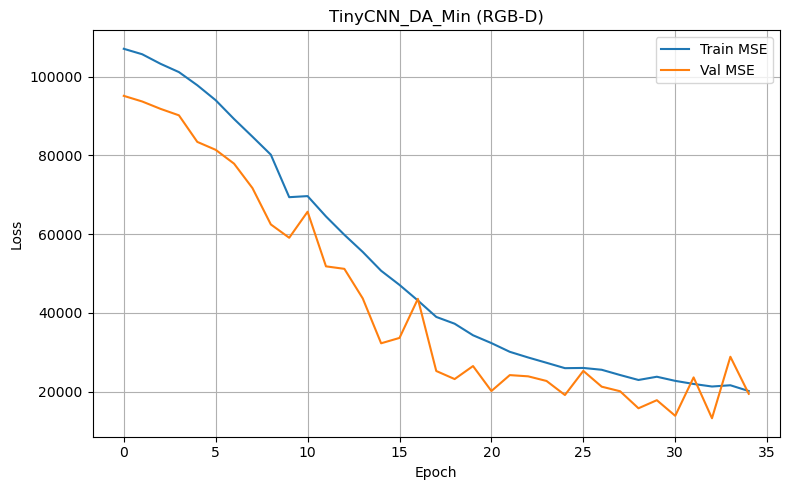

In [ ]:
train_tinycnn_da_rgbd_8()

>>> device: cuda - NVIDIA GeForce RTX 3070
RGB mean/std from dataset: [0.47934868616431653, 0.4638074891909204, 0.43293778049969917] [0.2311527546036717, 0.2420149695307458, 0.26527052063049217]
Epoch 001 | Train 105592.5702 | Val MSE 93381.7013 | Val MAE 222.70
Epoch 002 | Train 104018.9925 | Val MSE 90929.8742 | Val MAE 218.02
Epoch 003 | Train 101136.7260 | Val MSE 88090.4341 | Val MAE 212.87
Epoch 004 | Train 97295.2199 | Val MSE 84982.3600 | Val MAE 207.49
Epoch 005 | Train 94184.5385 | Val MSE 81666.9294 | Val MAE 202.04
Epoch 006 | Train 90530.1524 | Val MSE 78193.5341 | Val MAE 196.58
Epoch 007 | Train 86832.2054 | Val MSE 74610.8189 | Val MAE 191.17
Epoch 008 | Train 83108.2333 | Val MSE 70969.2029 | Val MAE 186.03
Epoch 009 | Train 79290.8773 | Val MSE 67321.6106 | Val MAE 181.22
Epoch 010 | Train 75293.0849 | Val MSE 63723.7003 | Val MAE 176.79
Epoch 011 | Train 71554.4168 | Val MSE 60233.9615 | Val MAE 172.92
Epoch 012 | Train 67391.3107 | Val MSE 56913.8315 | Val MAE 169.8

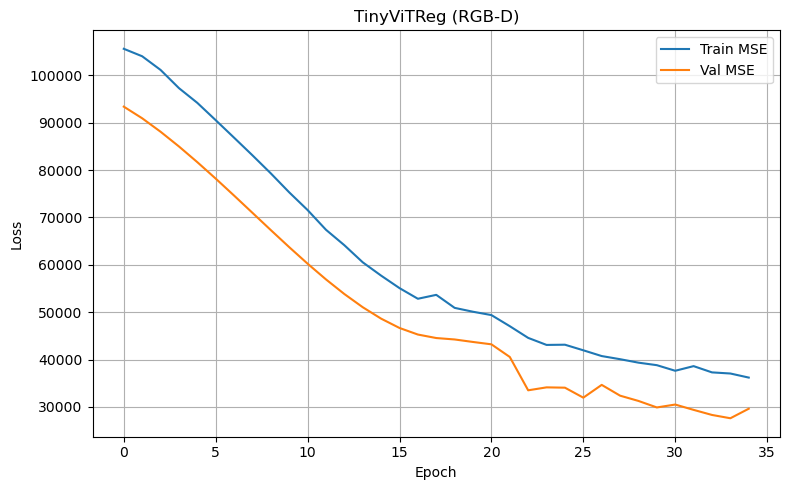

In [43]:
# ---------------------- TinyViT (RGB-D regression, from scratch) ----------------------
import math
from dataclasses import dataclass

class PatchEmbed(nn.Module):
    """
    Conv2d patchify + projection.
    Input:  (B, C_in, H, W)
    Output: (B, N, C) where N = (H/ps)*(W/ps), C=embed_dim
    """
    def __init__(self, img_size=384, patch_size=16, in_ch=4, embed_dim=96):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B,C,H,W) -> (B,embed_dim,H/ps,W/ps) -> (B,N,C)
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=3, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)                              # (B,N,3C)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)               # (3,B,H,N,d)
        q, k, v = qkv[0], qkv[1], qkv[2]               # (B,H,N,d)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B,H,N,N)
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v                                   # (B,H,N,d)
        x = x.transpose(1, 2).reshape(B, N, C)         # (B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn  = MultiHeadSelfAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp   = MLP(dim, hidden_features=int(dim*mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

def trunc_normal_(tensor, mean=0., std=0.02, a=-2., b=2.):
    # simplified truncated normal init (close to timm)
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2*l - 1, 2*u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
    return tensor

@dataclass
class TinyViTConfig:
    img_size: int = 384
    patch_size: int = 32
    in_ch: int = 4          # RGB(3) + depth(1)
    embed_dim: int = 192
    depth: int = 10
    num_heads: int = 3
    mlp_ratio: float = 3.0
    drop_rate: float = 0.0
    attn_drop_rate: float = 0.0

class TinyViTReg(nn.Module):
    """
    Minimal Tiny ViT for regression on RGB-D.
    forward(rgb, depth) -> (B,1)
    """
    def __init__(self, cfg: TinyViTConfig):
        super().__init__()
        self.cfg = cfg
        self.patch_embed = PatchEmbed(cfg.img_size, cfg.patch_size, cfg.in_ch, cfg.embed_dim)
        N = self.patch_embed.num_patches

        # Learnable 1D positional embedding for patch tokens only (no [CLS], we use mean pooling)
        self.pos_embed = nn.Parameter(torch.zeros(1, N, cfg.embed_dim))
        self.pos_drop  = nn.Dropout(p=cfg.drop_rate)

        self.blocks = nn.ModuleList([
            Block(cfg.embed_dim, cfg.num_heads, cfg.mlp_ratio, drop=cfg.drop_rate, attn_drop=cfg.attn_drop_rate)
            for _ in range(cfg.depth)
        ])
        self.norm = nn.LayerNorm(cfg.embed_dim, eps=1e-6)
        self.head = nn.Linear(cfg.embed_dim, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None: nn.init.zeros_(m.bias)
        trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, rgb, depth):
        # Concatenate along channel: (B,3,H,W) + (B,1,H,W) -> (B,4,H,W)
        x = torch.cat([rgb, depth], dim=1)
        x = self.patch_embed(x)                 # (B,N,C)
        x = x + self.pos_embed                  # (B,N,C)
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x.mean(dim=1)                       # mean pooling over tokens
        y = self.head(x)                        # (B,1)
        return y

# ---------------------- Train entry for TinyViT ----------------------
def train_tinyvit_rgbd_min():
    """
    Minimal training entry: same CSV / Dataset / Loader as your CNN.
    Change hyperparams here if needed.
    """
    set_seed(7)
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device("cuda" if torch.cuda.is_available()
                      else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
                            else "cpu"))
    print(">>> device:", (f"cuda - {torch.cuda.get_device_name(0)}" if device.type=="cuda" else device.type))

    train_csv = "train_index.csv"

    # 1) RGB mean/std
    mean_rgb, std_rgb = compute_rgb_mean_std_from_csv(train_csv, root='.')
    print("RGB mean/std from dataset:", mean_rgb, std_rgb)

    # 2) split indices
    tmp_ds_for_len = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds_for_len)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    # 3) datasets/loaders
    #    IMPORTANT: out_size must match cfg.img_size; default 384 for this minimal config.
    out_size = (384, 384)
    train_full = RGBDDataset(train_csv, out_size=out_size, augment=True,  mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(train_csv, out_size=out_size, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    # 4) model
    cfg = TinyViTConfig(
        img_size=out_size[0],
        patch_size=16,
        in_ch=4,            # RGB+Depth
        embed_dim=96,
        depth=8,
        num_heads=3,
        mlp_ratio=3.0,
        drop_rate=0.0,
        attn_drop_rate=0.0
    )
    model = TinyViTReg(cfg).to(device)

    # 5) optimizer & scheduler (minimal)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # optional cosine schedule; for minimality you can comment it out
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=35)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 35

    for ep in range(1, EPOCHS + 1):
        # ---- train ----
        model.train()
        total, n = 0.0, 0
        for (rgb, depth), y, _ in train_loader:
            rgb   = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)
            y     = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            pred = model(rgb, depth)
            loss = F.mse_loss(pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total += loss.item() * y.size(0)
            n     += y.size(0)
        tr = total / max(1, n)
        train_losses.append(tr)

        # ---- eval ----
        val = evaluate(model, val_loader, device)
        val_losses.append(val["MSE"])

        if isinstance(scheduler, torch.optim.lr_scheduler._LRScheduler):
            scheduler.step()

        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")

        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "vit_rgbd",
                "cfg": cfg.__dict__,
            }, "tinyvit_rgbd_best.pth")

    # ---- plot ----
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyViTReg (RGB-D)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# ---------------------- Main (choose which to run) ----------------------
if __name__ == "__main__":
    # 运行 TinyViT 版本（如需跑你原来的 CNN，调用 train_tinycnn_da_rgbd_8()）
    train_tinyvit_rgbd_min()


In [26]:
import os, csv, random, math, time
from typing import Tuple, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision.models import resnet18

# ---------------------- Depth-aware Resnet ----------------------
class DepthAwareConv2dLite(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1, bias=False, alpha_init=8.0):
        super().__init__()
        self.k, self.s, self.p = 3, stride, padding
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, 3, 3))
        nn.init.kaiming_normal_(self.weight, mode='fan_out', nonlinearity='relu')
        self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))
        self.center_idx = 4

    @staticmethod
    def _norm01(D, eps=1e-6):
        dmin = D.amin(dim=(2,3), keepdim=True)
        dmax = D.amax(dim=(2,3), keepdim=True)
        return (D - dmin) / (dmax - dmin + eps)

    def forward(self, x, depth):
        B, C, H, W = x.shape
        D = self._norm01(depth)
        k, s, p = self.k, self.s, self.p
        x_win = F.unfold(x, kernel_size=k, padding=p, stride=s)
        D_win = F.unfold(D, kernel_size=k, padding=p, stride=s)
        L = x_win.shape[-1]
        D_win = D_win.view(B, k*k, L)
        D_ctr = D_win[:, self.center_idx:self.center_idx+1, :]
        alpha = F.softplus(self.alpha_raw)
        score = -alpha * (D_ctr - D_win).abs()
        a = torch.softmax(score, dim=1)
        x_win = x_win.view(B, C, k*k, L)
        x_mod = (x_win * a[:, None, :, :]).view(B, C*k*k, L)
        Wmat = self.weight.view(self.weight.shape[0], -1)  # [out_ch, in_ch*k*k]
        y_cols = torch.einsum('oc,bcl->bol', Wmat, x_mod)
        H_out = (H + 2*p - k)//s + 1
        W_out = (W + 2*p - k)//s + 1
        return y_cols.view(B, -1, H_out, W_out)

class DAConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, s=1, alpha_init=8.0):
        super().__init__()
        self.conv = DepthAwareConv2dLite(in_ch, out_ch, stride=s, padding=1, bias=False, alpha_init=alpha_init)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x, depth):
        return self.act(self.bn(self.conv(x, depth)))

# ---------------------- Depth-Aware ResNet + Proxy + MLP ----------------------
class DepthProxyPhysical(nn.Module):
    def __init__(self, A_px_cm2=5.957e-3, Z_plane_cm=35.9, unit_per_m=10000):
        super().__init__()
        self.A_px_cm2 = A_px_cm2
        self.Z_plane_m = Z_plane_cm / 100.0
        self.unit_per_m = unit_per_m

    @torch.no_grad()
    def forward(self, depth_raw_uint16):
        Z_cam = depth_raw_uint16.float() / self.unit_per_m
        Z_cam = torch.clamp(Z_cam, 0.0, self.Z_plane_m)
        valid = (Z_cam > 0)

        B = Z_cam.shape[0]
        q80 = []
        for b in range(B):
            v = Z_cam[b,0][valid[b,0]]
            q80.append(torch.quantile(v, 0.8) if v.numel()>0 else torch.tensor(self.Z_plane_m, device=Z_cam.device))
        q80 = torch.stack(q80).view(B,1,1,1)

        mask_food = valid & (Z_cam <= q80)
        area_cm2 = mask_food.float().sum(dim=(1,2,3)) * self.A_px_cm2
        h_m = torch.clamp(self.Z_plane_m - Z_cam, min=0.0)
        tint_cm3 = (h_m * mask_food).sum(dim=(1,2,3)) * (self.A_px_cm2 * 100.0)
        return torch.stack([area_cm2, tint_cm3], dim=1)

# ---------------------- Dataset (RGB + Depth) ----------------------
class RGBDDataset(Dataset):
    """
    CSV columns: dish_id,label,rgb_path,depth_color_path,depth_raw_path
    Returns: (rgb, depth), y, dish_id
      - rgb: normalized by your dataset mean/std (float32, [3,H,W])
      - depth: depth_raw uint16 -> meters -> clip -> [0,1] (float32, [1,H,W])
    """
    def __init__(self, csv_file, out_size=(384,384), augment=True,
                 mean_rgb=(0,0,0), std_rgb=(1,1,1)):
        super().__init__()
        self.H, self.W = out_size
        self.augment = augment

        self.rows = []
        with open(csv_file, "r") as f:
            reader = csv.reader(f)
            header = next(reader)
            col = {h:i for i,h in enumerate(header)}
            for r in reader:
                self.rows.append({
                    "dish_id": r[col["dish_id"]],
                    "label": float(r[col["label"]]),
                    "rgb": r[col["rgb_path"]],
                    "drgb": r[col["depth_color_path"]],
                    "draw": r[col["depth_raw_path"]],
                })
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)  # [0,1], [3,H,W]

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)  # uint16 raw, 1m = 10000
        if d is None:
            # 返回 0 表示无效像素，保持与 proxy 逻辑一致
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        # 不做任何归一/裁剪；保持“raw depth 单位”
        d = d.astype(np.float32)                # [H,W], 例如 0..4000
        d = torch.from_numpy(d).unsqueeze(0)    # [1,H,W]
        return d

    def _augment_rgb_only(self, rgb):
        scale = random.uniform(0.7, 1.0)
        h,w = rgb.shape[-2:]
        th,tw = int(h*scale), int(w*scale)
        i = random.randint(0, h-th) if th < h else 0
        j = random.randint(0, w-tw) if tw < w else 0
        rgb = TF.resized_crop(rgb, i, j, th, tw, (self.H,self.W))
        ang = random.uniform(-8,8)
        rgb = TF.rotate(rgb, ang)
        if random.random() < 0.5: rgb = TF.hflip(rgb)
        rgb = TF.adjust_brightness(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_contrast(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_saturation(rgb,1+random.uniform(-0.2,0.2))
        rgb = TF.adjust_hue(rgb,random.uniform(-0.04,0.04))
        return rgb

    def __getitem__(self, idx):
        row = self.rows[idx]
        y = torch.tensor([row["label"]], dtype=torch.float32)

        rgb_path   = row["rgb"]
        depth_path = row["draw"]

        rgb   = self._load_rgb(rgb_path)
        depth = self._load_depth_raw(depth_path)

        if self.augment:
            rgb = self._augment_rgb_only(rgb)
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)
        else:
            rgb   = TF.resize(rgb,   (self.H,self.W))
            depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)

        return (rgb, depth), y, row["dish_id"]

    def __len__(self): return len(self.rows)

# ---------------------- Utils ----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def make_loader(dataset, batch_size, shuffle, drop_last):
    num_workers = 0
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available(),
                      drop_last=drop_last)

# ---------------------- Eval / Train ----------------------
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); mse_sum=mae_sum=n=0.0
    for (rgb, depth), y, _ in loader: 
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        p = model(rgb, depth) 
        mse_sum += F.mse_loss(p, y, reduction="sum").item()
        mae_sum += torch.abs(p - y).sum().item()
        n += y.size(0)
    return {"MSE":mse_sum/n, "MAE":mae_sum/n}

def train_one_epoch(model, loader, optimizer, device, max_grad_norm=1.0):
    model.train()
    total, n = 0.0, 0
    for (rgb, depth), y, _ in loader:  # <- 只解包 rgb, depth
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        y     = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(rgb, depth)  # <- 不再传 plate_mask
        loss = F.mse_loss(pred, y)
        loss.backward()
        if max_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total += loss.item() * y.size(0)
        n     += y.size(0)
    return total / max(1, n)

class DepthAwareResNet18ProxyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # depth-aware stem
        self.stem_da = DAConvBNReLU(3, 64, s=2, alpha_init=4.0)
        self.maxpool = nn.MaxPool2d(3,2,1)

        # backbone
        base = resnet18(weights=None)  # no pretrain
        self.layer1, self.layer2 = base.layer1, base.layer2
        self.layer3, self.layer4 = base.layer3, base.layer4
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = 512

        # simple proxy: (area_cm2, tint_cm3)  不使用 plate_mask
        self.proxy = DepthProxyPhysical()

        # head: concat 512+2 -> 256 -> 64 -> 1
        self.head = nn.Sequential(
            nn.Linear(self.feat_dim + 2, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, rgb, depth_raw_uint16):
        # depth-aware stem（将原始 depth 单位 1m=10000 归一化到[0,1]喂 DA 卷积）
        x = self.stem_da(rgb, depth_raw_uint16 / 10000.0)
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        feat = self.avgpool(x).flatten(1)  # [B,512]

        # proxy（无 mask）
        proxy = self.proxy(depth_raw_uint16)  # [B,2]

        z = torch.cat([feat, proxy], dim=1)
        return self.head(z)  # [B,1]
    
# ---------------------- Main ----------------------

def train_resnet_mlp():
    set_seed(7)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_csv = "train_index_log.csv"

    # 1) compute dataset mean/std on RGB (training CSV)
    # mean_rgb, std_rgb = compute_rgb_mean_std_from_csv(train_csv, root='.')
    mean_rgb=(0.48711928725242615, 0.470241904258728, 0.4376976788043976)
    std_rgb= (0.22217294573783875, 0.23592297732830048, 0.2618241310119629)
    print("RGB mean/std from dataset:", mean_rgb, std_rgb)

    # 2) split indices
    tmp_ds_for_len = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    idx = list(range(len(tmp_ds_for_len)))
    random.shuffle(idx)
    k = max(1, int(0.2 * len(idx)))  # 80/20 split
    val_idx, train_idx = idx[:k], idx[k:]

    # 3) datasets/loaders
    train_full = RGBDDataset(train_csv, augment=False,  mean_rgb=mean_rgb, std_rgb=std_rgb)
    val_full   = RGBDDataset(train_csv, augment=False, mean_rgb=mean_rgb, std_rgb=std_rgb)
    train_ds = Subset(train_full, train_idx)
    val_ds   = Subset(val_full,   val_idx)

    train_loader = make_loader(train_ds, batch_size=64, shuffle=True,  drop_last=True)
    val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False, drop_last=False)

    # 4) model (depth-aware)
    model = DepthAwareResNet18ProxyMLP().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    train_losses, val_losses = [], []
    best_val = float("inf")
    EPOCHS = 22

    for ep in range(1, EPOCHS + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device)
        val = evaluate(model, val_loader, device)
        train_losses.append(tr); val_losses.append(val["MSE"])
        print(f"Epoch {ep:03d} | Train {tr:.4f} | Val MSE {val['MSE']:.4f} | Val MAE {val['MAE']:.2f}")
        if val["MSE"] < best_val:
            best_val = val["MSE"]
            torch.save({
                "model": model.state_dict(),
                "mode": "rgbd_da",
                "in_ch": 3,
            }, "tinycnn_da_rgbd_best.pth")

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train MSE")
    plt.plot(val_losses, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("TinyCNN_DA_Min (RGB-D)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    



In [ ]:
train_resnet_mlp()

RGB mean/std from dataset: (0.48711928725242615, 0.470241904258728, 0.4376976788043976) (0.22217294573783875, 0.23592297732830048, 0.2618241310119629)


C:\Users\Admin\AppData\Local\Temp\ipykernel_46984\3767364801.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))


Epoch 001 | Train 4.3437 | Val MSE 1.4251 | Val MAE 1.01
Epoch 002 | Train 0.9950 | Val MSE 1.2665 | Val MAE 0.86


In [20]:
# ---------------------- Test Folder Inference (append-only) ----------------------
class TestFolderDataset(Dataset):
    """
    只读测试集：根目录下有 rgb/ depth_raw/ (可有 depth_color/)，其下按 dish_id 子目录。
    每个 dish_id 取第一个图。无 label。
    返回: (rgb, depth), dish_id
    """
    def __init__(self, root_dir, out_size=(384,384), mean_rgb=(0,0,0), std_rgb=(1,1,1)):
        super().__init__()
        self.root = root_dir
        self.H, self.W = out_size
        self.mean_rgb = torch.tensor(mean_rgb, dtype=torch.float32).view(3,1,1)
        self.std_rgb  = torch.tensor(std_rgb,  dtype=torch.float32).view(3,1,1)

        self.rgb_root  = os.path.join(root_dir, "color")
        self.draw_root = os.path.join(root_dir, "depth_raw")

        # 收集 dish_id
        ids = set()
        if os.path.isdir(self.rgb_root):
            ids |= set([d for d in os.listdir(self.rgb_root) if os.path.isdir(os.path.join(self.rgb_root, d))])
        if os.path.isdir(self.draw_root):
            ids |= set([d for d in os.listdir(self.draw_root) if os.path.isdir(os.path.join(self.draw_root, d))])
        self.dish_ids = sorted(list(ids))

    def _first_png(self, dirpath):
        if not os.path.isdir(dirpath): return ""
        for f in sorted(os.listdir(dirpath)):
            if f.lower().endswith(".png"):
                return os.path.join(dirpath, f)
        return ""

    def _load_rgb(self, p):
        img = Image.open(p).convert("RGB")
        return TF.to_tensor(img)

    def _load_depth_raw(self, p):
        d = cv2.imread(p, cv2.IMREAD_ANYDEPTH)
        if d is None:
            return torch.zeros(1, self.H, self.W, dtype=torch.float32)
        d = d.astype(np.float32)              # 原始单位: 1m=10000
        return torch.from_numpy(d)[None, ...] # [1,H,W]

    def __len__(self): return len(self.dish_ids)

    def __getitem__(self, idx):
        did = self.dish_ids[idx]
        rgb_p  = self._first_png(os.path.join(self.rgb_root,  did))
        draw_p = self._first_png(os.path.join(self.draw_root, did))
        if rgb_p == "" or draw_p == "":
            # 占位，避免崩溃
            rgb  = torch.zeros(3, self.H, self.W, dtype=torch.float32)
            depth= torch.zeros(1, self.H, self.W, dtype=torch.float32)
        else:
            rgb   = self._load_rgb(rgb_p)
            depth = self._load_depth_raw(draw_p)

        # resize（保持对齐）
        rgb   = TF.resize(rgb,   (self.H,self.W))
        depth = TF.resize(depth, (self.H,self.W), interpolation=InterpolationMode.NEAREST)

        # 与训练一致的归一化
        rgb = (rgb - self.mean_rgb) / (self.std_rgb + 1e-6)
        return (rgb, depth), did

@torch.no_grad()
def infer_test_folder(model_cls, ckpt_path, test_dir, mean_rgb, std_rgb,
                      out_csv="submission.csv", img_size=384, batch_size=64, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # 1) 构建同结构模型并加载best权重
    model = model_cls().to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    # 2) 构建测试集 DataLoader
    test_ds = TestFolderDataset(test_dir, out_size=(img_size, img_size),
                                mean_rgb=mean_rgb, std_rgb=std_rgb)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=torch.cuda.is_available())

    # 3) 推理
    results = []
    for (rgb, depth), did in test_loader:
        rgb   = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)
        pred  = model(rgb, depth)             # [B,1]
        pred  = pred.squeeze(1).detach().cpu().numpy().tolist()
        did   = list(did)
        for d, p in zip(did, pred):
            results.append((d, float(p)))

    # 4) 写出 CSV（Kaggle/比赛常见格式：dish_id,prediction）
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["ID", "Value"])
        w.writerows(results)
    print(f"[OK] wrote {len(results)} rows -> {out_csv}")

In [21]:
TEST_DIR = r".\Nutrition5K\Nutrition5K\test"   # <<< 换成你的测试集根目录
infer_test_folder(
    model_cls=DepthAwareResNet18ProxyMLP,
    ckpt_path="tinycnn_da_rgbd_best.pth",
    test_dir=TEST_DIR,
    mean_rgb=(0.48711928725242615, 0.470241904258728, 0.4376976788043976),
    std_rgb= (0.22217294573783875, 0.23592297732830048, 0.2618241310119629),
    out_csv="submission.csv",
    img_size=480,
    batch_size=64,
    device="cuda"
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_46984\3405847383.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_raw = nn.Parameter(torch.tensor(torch.log(torch.exp(torch.tensor(alpha_init)) - 1.0)))


[OK] wrote 189 rows -> submission.csv
